### Problem Statement

Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.
Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017,
920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR)
by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams.
Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of
pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid
overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-
radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also
appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at
different time points and correlation with clinical symptoms and history are helpful in making the
diagnosis.
CXRs are the most commonly performed diagnostic imaging study. A number of factors such as
positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating
interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.
Pneumonia Detection
Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re
challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically,
your algorithm needs to automatically locate lung opacities on chest radiographs.

### Objectives

The objective of the project is,
- Learn to how to do build an Object Detection Model
- Use transfer learning to fine-tune a model.
- Learn to
- Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.

#### Import the Libraries

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow as tf
import os
import pydicom
import cv2
from glob import glob
from matplotlib.patches import Rectangle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tqdm import tqdm_notebook
from tqdm import tqdm
import seaborn as sns

import random


# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

#### Image Properties Below

In [2]:
img_size = 224
image_width = 224
image_height = 224
height_cells = 28
width_cells = 28
alpha = 1

#### Change to the current project directory

In [3]:
os.chdir('/Volumes/Ayon_Drive/GreatLearning/Capstone_Pneumonia')

#### Name of training and test images and bounding box details below

In [4]:
det_class_info = 'stage_2_detailed_class_info.csv'
train_bbox = 'stage_2_train_labels.csv'
train_img_dcm = "stage_2_train_images"
test_img_dcm = "stage_2_test_images"
train_img_dir_jpg = 'JPG_train'
test_img_dir_jpg = 'JPG_test'

### Pre-Processing, Data Visualization, EDA

### Exploratory Data Analysis (EDA) Here as a part of EDA, we will:

Start with understanding of the data with a brief on train/test labels and respective class info Look at the first five rows of both the csvs (train and test) Identify how are classes and target distributed Check the number of patients with 1, 2, ... bounding boxes Read and extract metadata from dicom files Perform analysis on some of the features from dicom files Check some random images from the training dataset Draw insights from the data at various stages of EDA

Reading CSVs Images for the current stage in the stage_2_train_images and stage_2_test_images. Training data: stage_2_train_labels.csv stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

#### Loading detailed class info file

In [5]:
class_df = pd.read_csv(det_class_info)

In [6]:
print("\nClass dataframe has 30227 rows and 2 columns:")
class_df.shape


Class dataframe has 30227 rows and 2 columns:


(30227, 2)

In [7]:
print("\nClass dataframe first 5 rows:")
class_df.head()


Class dataframe first 5 rows:


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [8]:
print('Total No of Patients in Class Info', class_df['patientId'].value_counts().shape[0])

Total No of Patients in Class Info 26684


In [9]:
print('Total distinct classes: ', class_df['class'].unique())

Total distinct classes:  ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


#### We see there are 3 classes, Normal, Lung Opacity and No Lung Opacity/Not Normal
#### No Lung Opacity/Not Normal are cases that look like opacity but are not. 

#### Check for duplicates in patient id

In [10]:
##Identify duplicates records in the data
dupes = class_df['patientId'].duplicated()
sum(dupes)

3543

#### 3543 patients have duplicates in class info

<AxesSubplot:xlabel='class'>

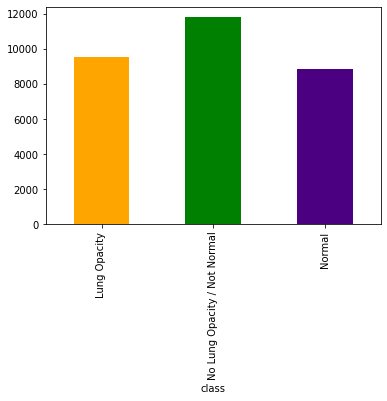

In [11]:
class_df.groupby('class').size().plot.bar(5, 10, color=['Orange', 'green', 'Indigo'])

#### Load CSV file containing training set patientIds and labels (Bounding Boxes)

In [12]:
labels_df = pd.read_csv(train_bbox)

In [13]:
print("\nLabel dataframe first 5 rows:")
labels_df.head()


Label dataframe first 5 rows:


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


#### We see patient ids, and bounding box is present in the dataset. 0 means No Pneumonia, 1 means Pneumonia
#### Bounding Box is not present when the patient doesnot have pneumonia, however 0 can mean No Lung Opacity/Not Normal¶

In [14]:
print(f'Train Labels dataframe has {labels_df.shape[0]} rows and {labels_df.shape[1]} columns')

Train Labels dataframe has 30227 rows and 6 columns


#### Converting Not a number to 0

In [15]:
labels_df['x'] = labels_df['x'].replace(np.nan, 0)
labels_df['y'] = labels_df['y'].replace(np.nan, 0)
labels_df['width'] = labels_df['width'].replace(np.nan, 0)
labels_df['height'] = labels_df['height'].replace(np.nan, 0)

In [16]:
print("\nUpdated data samples:")
labels_df.head()


Updated data samples:


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


#### There are 30,227 patient ids

#### Checking the dataset information

In [17]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [18]:
labels_df.describe()

,x,y,width,height,Target
count,30227.000000,30227.000000,30227.000000,30227.000000,30227.000000
mean,124.561683,115.960962,69.060575,104.084825,0.316108
std,216.326397,190.012883,106.910496,176.932152,0.464963
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,193.000000,231.000000,169.000000,188.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


#### Checking duplicates if it matches with class info file

In [19]:
##Identify duplicates records in the data
dupes = labels_df['patientId'].duplicated()
sum(dupes)

3543

#### 3543 patients have multiple X rays

#### Check for missing values

In [20]:
print(" \nCount total NaN at each column in the dataset : \n\n", 
      labels_df.isnull().sum())

 
Count total NaN at each column in the dataset : 

 patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64


#### From the above we see there are no null values

Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


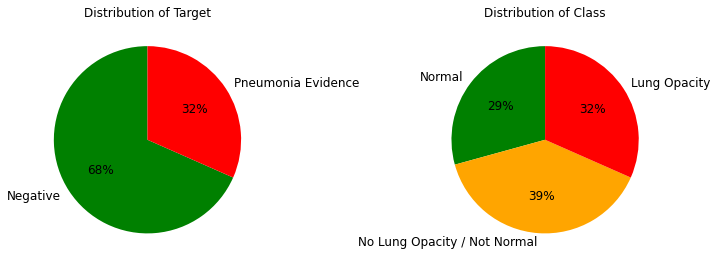

In [21]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (labels_df['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['green', 'red'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_df['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['green', 'orange', 'red'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

### We will check the number of boxes for each patient

In [22]:
box_patient_df = labels_df.groupby('patientId').size().reset_index(name='boxes')
box_patient_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


In [23]:
labels_class_df = pd.merge(labels_df, class_df, how='inner', on='patientId')
print('Total Cases : ', labels_class_df.shape[0])

Total Cases :  37629


#### Since there are duplicate patient ids in both the datasets we see an increase in the number of rows
#### Instead of doing inner join lets try to concat both the datasets

In [24]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(class_df.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class_df = pd.concat([labels_df, class_df['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class_df.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 7)


In [25]:
train_class_df.head(5)


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


#### Observations from the CSVs Based on analysis above, some of the observations:

Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height. There are multiple records for patients. Number of duplicates in patientID = 3,543. There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia. Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity. Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class. Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class. About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!!!!

Reading Images Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [26]:
def checkXray(i, dirName):
    patientId = train_class_df['patientId'][i]
    print("Patient Id: ", patientId)
    fileName = dirName + "/" + patientId
    print("\nBounding Box Coordinates, X: ", train_class_df['x'][i])
    print("\nBounding Box Coordinates, Y: ", train_class_df['y'][i])
    print("\nBounding Box Coordinates, Width: ", train_class_df['width'][i])
    print("\nBounding Box Coordinates, Height: ", train_class_df['height'][i])
    
    patient_file = '%s.dcm' % fileName
    patient_data = pydicom.read_file(patient_file)
    print(patient_data)
    
    plt.imshow(patient_data.pixel_array,cmap=pl.cm.gist_gray)

#### Let's take a look into an image of a person who has normal lungs

Patient Id:  003d8fa0-6bf1-40ed-b54c-ac657f8495c5

Bounding Box Coordinates, X:  0.0

Bounding Box Coordinates, Y:  0.0

Bounding Box Coordinates, Width:  0.0

Bounding Box Coordinates, Height:  0.0
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2293.1517874295.733882
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(000

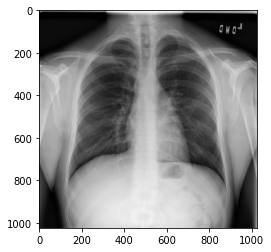

In [27]:
checkXray(3, train_img_dcm)

#### Let's take a look into an image of a person who has lung opacity

Patient Id:  00436515-870c-4b36-a041-de91049b9ab4

Bounding Box Coordinates, X:  264.0

Bounding Box Coordinates, Y:  152.0

Bounding Box Coordinates, Width:  213.0

Bounding Box Coordinates, Height:  379.0
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Stor

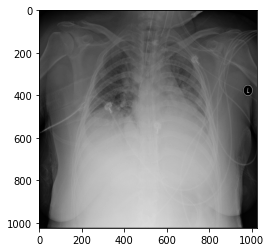

In [28]:
checkXray(4, train_img_dcm)

#### Let's take a look into an image of a person who has No Lung Opacity/Not Normal¶

Patient Id:  0004cfab-14fd-4e49-80ba-63a80b6bddd6

Bounding Box Coordinates, X:  0.0

Bounding Box Coordinates, Y:  0.0

Bounding Box Coordinates, Width:  0.0

Bounding Box Coordinates, Height:  0.0
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(00

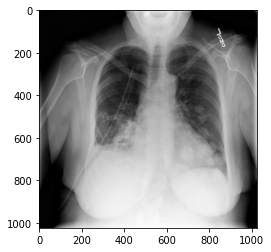

In [29]:
checkXray(0, train_img_dcm)

In [30]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = pydicom.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality

In [31]:
print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(train_img_dcm, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
assert images.shape[0] == len(list(set(train_class_df['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
--------------------------------------------------------------------------------
Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [32]:
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*40)
train_class_df = train_class_df.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class_df.shape))

Merge path from the `images` dataframe with `train_class` dataframe
--------------------------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 8)


In [33]:
train_class_df.head()

,patientId,x,y,width,height,Target,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...


In [34]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class_df, train_img_dcm)
print('Saving the feature engineered dataframe for future use'); print('--'*40)
train_class_df.to_pickle('train_feature_engineered.pkl')

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images



Saving the feature engineered dataframe for future use
--------------------------------------------------------------------------------


In [37]:
train_class_df = pd.read_pickle('train_feature_engineered.pkl')
train_class_df.shape

(30227, 13)

In [38]:
train_class_df.head()

,patientId,x,y,width,height,Target,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,F,32.0,CHEST,AP,CR


In [40]:
print('As expected unique in `BodyPartExamined` is: {}'.format(train_class_df['BodyPartExamined'].unique()[0]))
print('Unique in `Modality` is: {}'.format(train_class_df['Modality'].unique()[0])); print('--'*40)

As expected unique in `BodyPartExamined` is: CHEST
Unique in `Modality` is: CR
--------------------------------------------------------------------------------


Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------


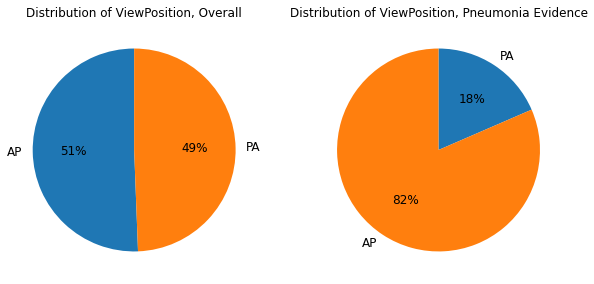

In [42]:
print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class_df['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class_df.loc[train_class_df['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Plot x and y centers of bounding boxes
--------------------------------------------------------------------------------


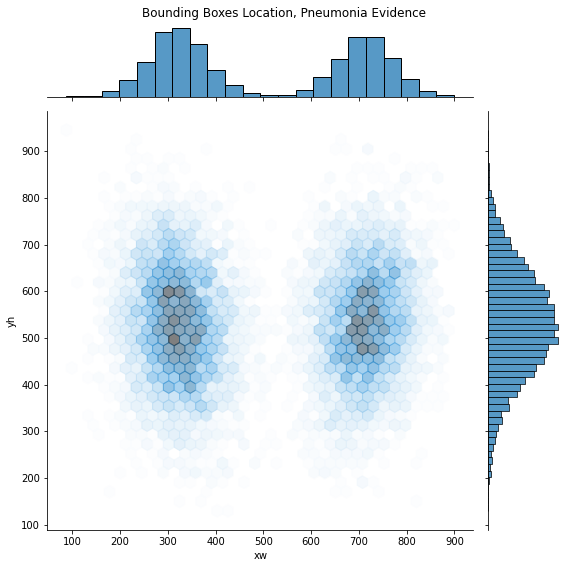

In [46]:
print('Plot x and y centers of bounding boxes'); print('--'*40)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class_df[train_class_df['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

In [48]:
# Helper function to plot bboxes scatter
# Reference for this function & plots: https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000


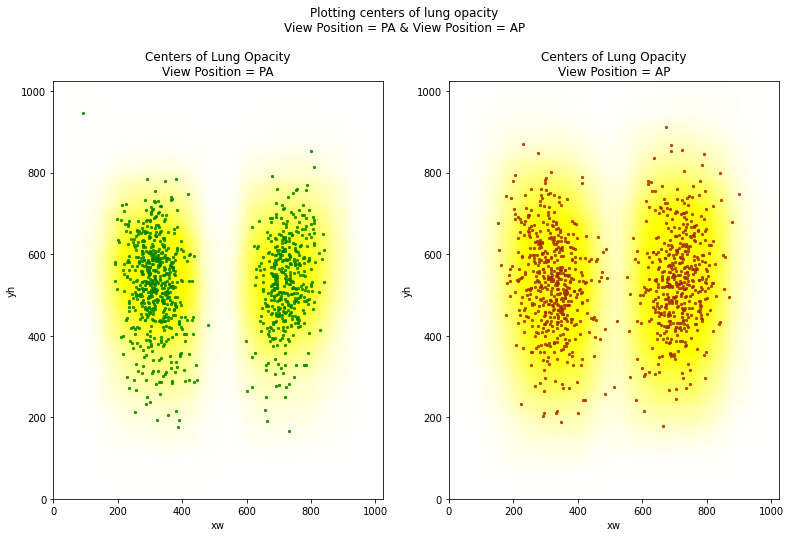

In [49]:
print('Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000')

df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

#### Observations: BodyPartExamined & ViewPosition Above we saw,

BodyPartExamined is unique for all cases and is CHEST in the training dataset and that was also expected. Unique in Modality is CR i.e. Computer Radiography Overall ViewPosition is almost equally distributed in the training dataset but for cases where Target=1, most of the view position are AP.

Checking outliers in `PatientAge
--------------------------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1.0
Maximum `PatientAge` in the training dataset: 100.0
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0



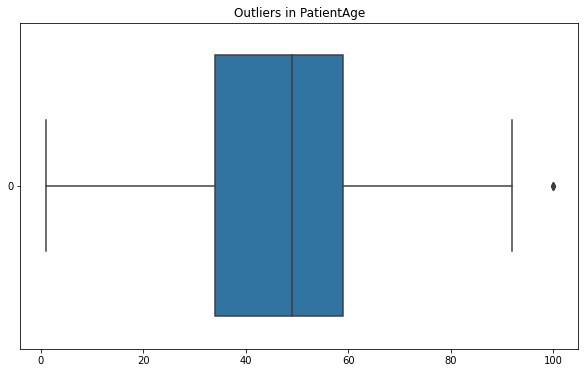

In [55]:
print('Checking outliers in `PatientAge'); print('--'*40)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class_df['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class_df['PatientAge'].quantile(0.75) + (train_class_df['PatientAge'].quantile(0.75) - train_class_df['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class_df['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

In [50]:
print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*40)
train_class_df['PatientAge'] = train_class_df['PatientAge'].clip(train_class_df['PatientAge'].min(), 100)
train_class_df['PatientAge'].describe().astype(int)

Using pd.clip to set upper threshold of 100 for age and remove outliers
--------------------------------------------------------------------------------


count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int64

Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------


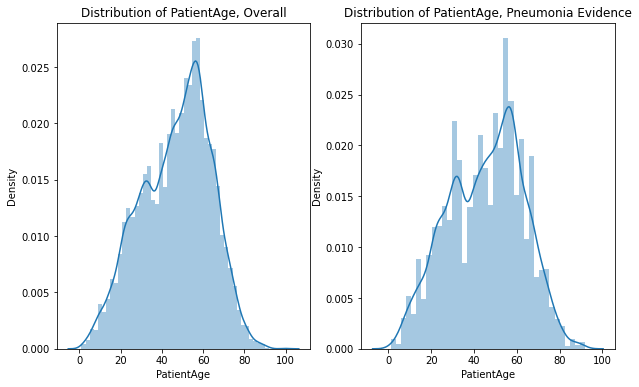

In [51]:
print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class_df['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class_df.loc[train_class_df['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))

#### Using Binning Method for PatientAge feature

We'll make use of a pd.cut which is 'Bin values into discrete intervals'. Use of this method is recommended when need is to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. Supports binning into an equal number of bins, or a pre-specified array of bins.

In [56]:
print('Creating Age Binning field', '--'*40)
train_class_df['AgeBins'] = pd.cut(train_class_df['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class_df['AgeBins'].value_counts()

Creating Age Binning field --------------------------------------------------------------------------------


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Value counts of the age bin field created
--------------------------------------------------------------------------------


,"Counts of Age Bins, Overall","Counts of Age Bins, Target=1"
<=26,3972,1478
<=50,12157,3917
<=75,13318,3895
<=100,780,265


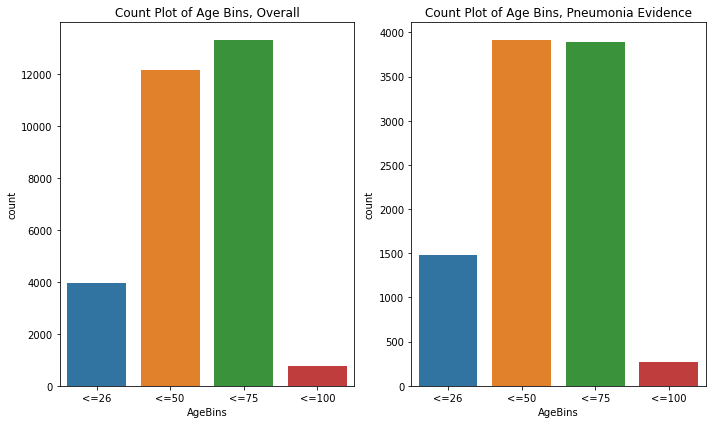

In [57]:
print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class_df['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class_df.loc[train_class_df['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class_df['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class_df.loc[train_class_df['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `AgeBins` for random sample = 200


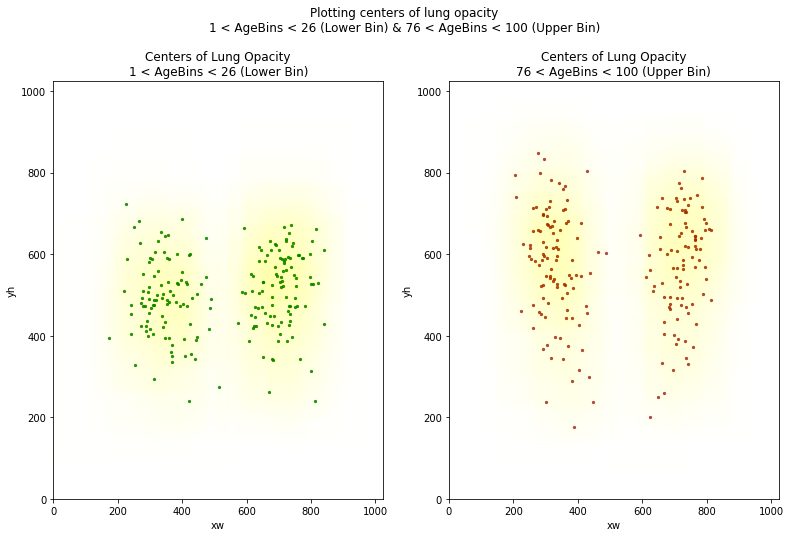

In [59]:
print('Exploring the bounding boxes centers for `AgeBins` for random sample = 200')
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class_df[train_class_df['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '<=26'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')


Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender
--------------------------------------------------------------------------------


,"% Gender, Overall","% Gender, Target=1"
F,0.43,0.42
M,0.57,0.58


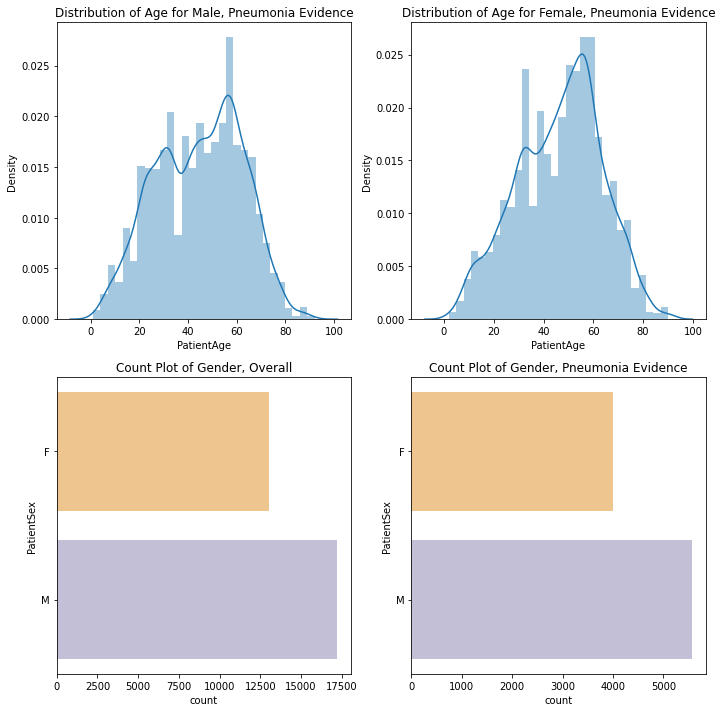

In [60]:
print('Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender'); print('--'*40)
display(pd.concat([train_class_df['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class_df.loc[(train_class_df['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class_df.loc[(train_class_df['Target'] == 1) & (train_class_df['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class_df.loc[(train_class_df['Target'] == 1) & (train_class_df['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class_df['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class_df.loc[(train_class_df['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `PatientSex` for random sample = 1000


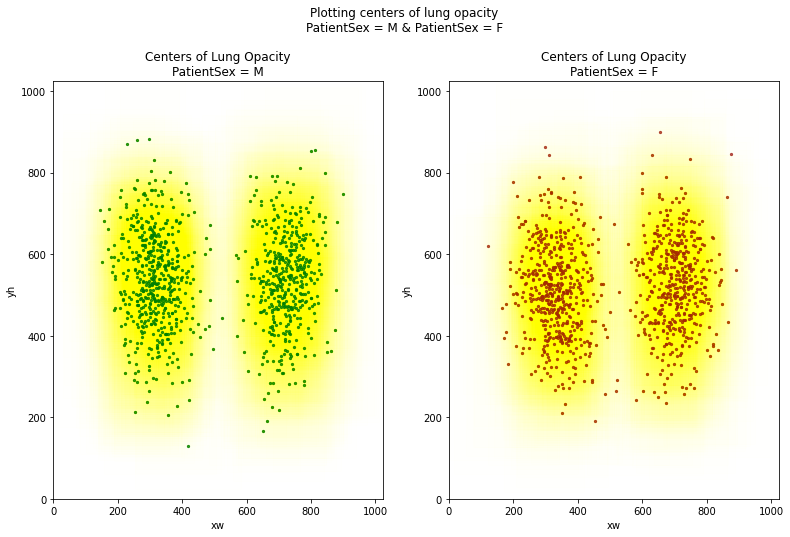

In [61]:

print('Exploring the bounding boxes centers for `PatientSex` for random sample = 1000')
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')


#### Observations: PatientAge & PatientSex Above we saw,

For PatientAge we saw the distribution for both overall and where there were evidence of Pneumonia. Used binning to check the count of age bins. Count was highest for age group 40-78 both overall and with Pneumonia Evidence. Saw distribution of age for Male and Female with Pneumonia Evidence. Dataset had more Males (57%-58%) than Females (42%-43%). Only PatientAge, PatientSex and ViewPosition are useful features from metadata.

Dropping the other features from train_class dataframe and save that as a pickle file

In [65]:
train_class_df.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
train_class_df.to_pickle('train_class_features.pkl')
display(train_class_df.shape, train_class_df.head())

(30227, 11)

,patientId,x,y,width,height,Target,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,F,32.0,AP


Checking sample for different classes


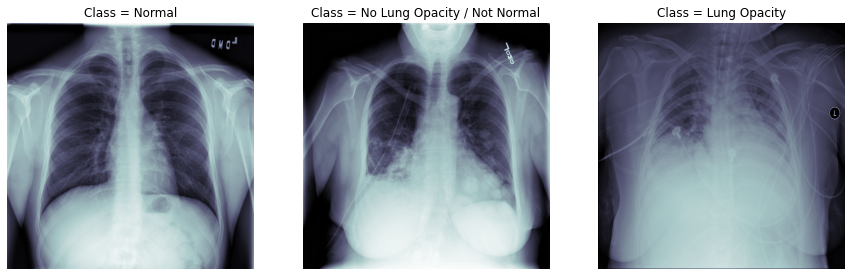

In [67]:
print('Checking sample for different classes')
sample1 = train_class_df.loc[train_class_df['class'] == 'Normal'].iloc[0]
sample2 = train_class_df.loc[train_class_df['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class_df.loc[train_class_df['class'] == 'Lung Opacity'].iloc[1]
ds1 = pydicom.dcmread(sample1['path'])
ds2 = pydicom.dcmread(sample2['path'])
ds3 = pydicom.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()


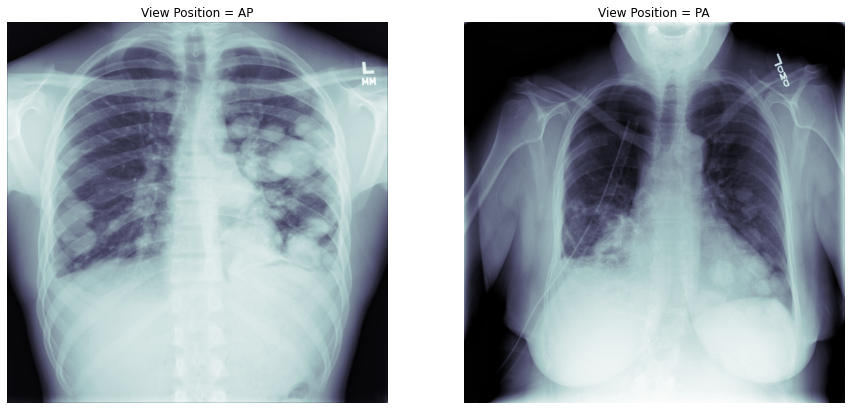

In [68]:

sample4 = train_class_df.loc[(train_class_df['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class_df.loc[(train_class_df['ViewPosition'] == 'PA')].iloc[0]
ds4 = pydicom.dcmread(sample4['path'])
ds5 = pydicom.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

In [72]:
# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = pydicom.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = pydicom.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

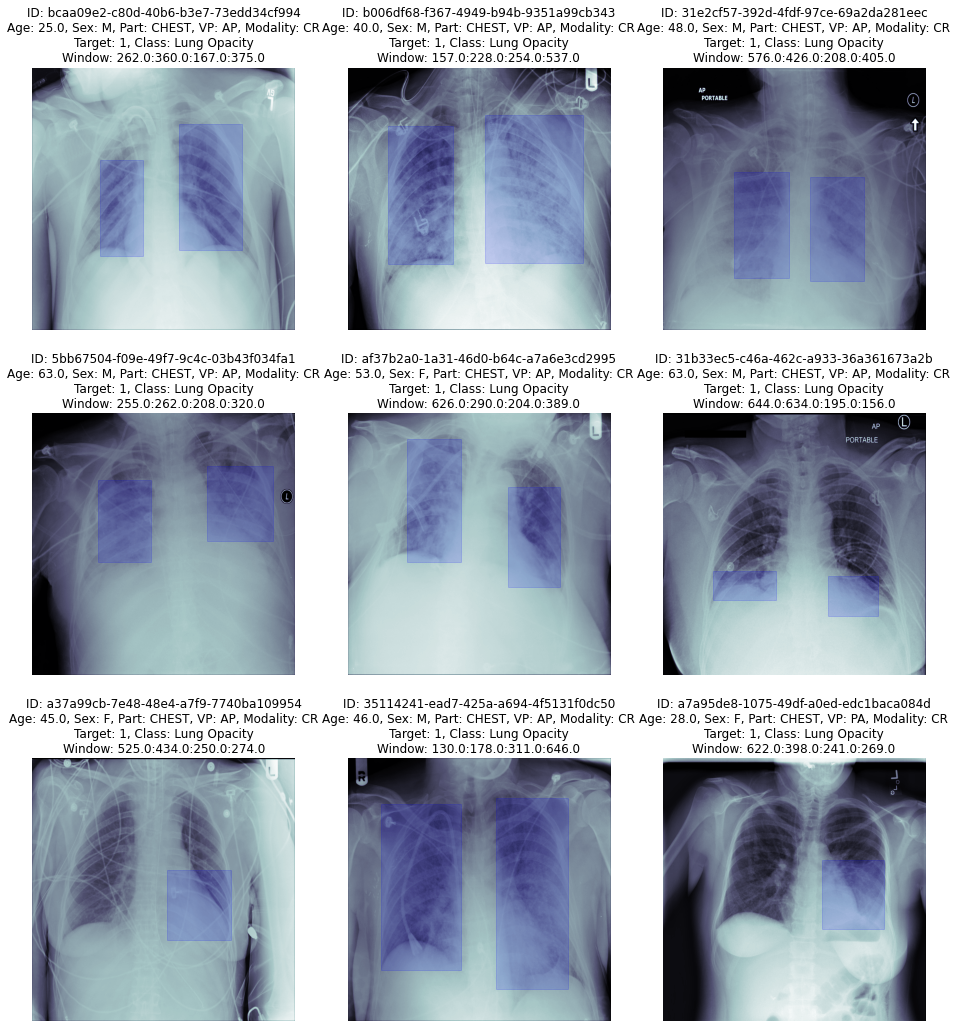

In [73]:
# this function is a part of custom module imported earlier (`eda`)
plot_dicom_images(data = train_class_df.loc[(train_class_df['Target'] == 1)].sample(9), 
                  df = train_class_df, img_path = train_img_dcm)

### Now we will convert the images from dcm to jpg for faster processing of data

In [ ]:
# if not os.path.exists(TRAIN_IMAGES): os.makedirs(TRAIN_IMAGES)
# if not os.path.exists(TEST_IMAGES): os.makedirs(TEST_IMAGES)

In [85]:
def convertImage(folder_path, jpg_folder_path):
    if not os.path.exists(jpg_folder_path): 
        os.makedirs(jpg_folder_path)
    images_path = os.listdir(folder_path)
    for n, image in enumerate(images_path):
        ds = pydicom.dcmread(os.path.join(folder_path, image))
        pixel_array_numpy = ds.pixel_array
        image = image.replace('.dcm', '.jpg')
        cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
        if n % 200 == 0:
            print('{} image converted'.format(n))

In [84]:
!ls

AIML- Capstone Overview.pdf             stage_2_train_images
GCP Credits Request Link - RSNA.txt     stage_2_train_images.zip
Pneumonia Detection Challenge Brief.pdf stage_2_train_labels.csv
stage_2_detailed_class_info.csv         train_class_features.pkl
stage_2_sample_submission.csv           train_feature_engineered.pkl
stage_2_test_images


#### Convert all training images

In [87]:
convertImage(train_img_dcm, train_img_dir_jpg)

0 image converted
200 image converted
400 image converted
600 image converted
800 image converted
1000 image converted
1200 image converted
1400 image converted
1600 image converted
1800 image converted
2000 image converted
2200 image converted
2400 image converted
2600 image converted
2800 image converted
3000 image converted
3200 image converted
3400 image converted
3600 image converted
3800 image converted
4000 image converted
4200 image converted
4400 image converted
4600 image converted
4800 image converted
5000 image converted
5200 image converted
5400 image converted
5600 image converted
5800 image converted
6000 image converted
6200 image converted
6400 image converted
6600 image converted
6800 image converted
7000 image converted
7200 image converted
7400 image converted
7600 image converted
7800 image converted
8000 image converted
8200 image converted
8400 image converted
8600 image converted
8800 image converted
9000 image converted
9200 image converted
9400 image converted

#### Convert all test images

In [86]:
convertImage(test_img_dcm, test_img_dir_jpg)

0 image converted
200 image converted
400 image converted
600 image converted
800 image converted
1000 image converted
1200 image converted
1400 image converted
1600 image converted
1800 image converted
2000 image converted
2200 image converted
2400 image converted
2600 image converted
2800 image converted


In [119]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class_df[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'JPG_train')
                             .str.replace('.dcm', '.jpg'))
path_class_target.drop_duplicates(inplace = True)
path_class_target = path_class_target.reset_index()
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 5)

index        26684
patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [120]:
path_class_target.head(10)

,index,patientId,path,class,Target
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,JPG_train/0004cfab-14fd-4e49-80ba-63a80b6bddd6...,No Lung Opacity / Not Normal,0
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,JPG_train/00313ee0-9eaa-42f4-b0ab-c148ed3241cd...,No Lung Opacity / Not Normal,0
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,JPG_train/00322d4d-1c29-4943-afc9-b6754be640eb...,No Lung Opacity / Not Normal,0
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,JPG_train/003d8fa0-6bf1-40ed-b54c-ac657f8495c5...,Normal,0
4,4,00436515-870c-4b36-a041-de91049b9ab4,JPG_train/00436515-870c-4b36-a041-de91049b9ab4...,Lung Opacity,1
5,6,00569f44-917d-4c86-a842-81832af98c30,JPG_train/00569f44-917d-4c86-a842-81832af98c30...,No Lung Opacity / Not Normal,0
6,7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,JPG_train/006cec2e-6ce2-4549-bffa-eadfcd1e9970...,No Lung Opacity / Not Normal,0
7,8,00704310-78a8-4b38-8475-49f4573b2dbb,JPG_train/00704310-78a8-4b38-8475-49f4573b2dbb...,Lung Opacity,1
8,10,008c19e8-a820-403a-930a-bc74a4053664,JPG_train/008c19e8-a820-403a-930a-bc74a4053664...,No Lung Opacity / Not Normal,0
9,11,009482dc-3db5-48d4-8580-5c89c4f01334,JPG_train/009482dc-3db5-48d4-8580-5c89c4f01334...,Normal,0


In [121]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_target['path'])
random.shuffle(image_list)
test_size = round(len(image_list)/10)
val_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


In [122]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTrain:{}\nValid:{}\nTest:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 4)
VALID:(2668, 4)
TEST:(2668, 4)


In [130]:
df_train.head(5)

,index,patientId,path,Target
0,237,06250f9d-5ad9-44ca-9283-dbf787e2ad22,JPG_train/06250f9d-5ad9-44ca-9283-dbf787e2ad22...,1
1,22869,ce421618-e170-4cb1-bab4-4faa22cac209,JPG_train/ce421618-e170-4cb1-bab4-4faa22cac209...,0
2,27896,f77599f5-8013-42b2-9504-de61474b302d,JPG_train/f77599f5-8013-42b2-9504-de61474b302d...,0
3,12123,7c595159-8258-45b3-bede-fde676d7e62e,JPG_train/7c595159-8258-45b3-bede-fde676d7e62e...,0
4,7142,548b0ce7-2797-4d24-814e-d419d2e82fb6,JPG_train/548b0ce7-2797-4d24-814e-d419d2e82fb6...,0


In [133]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21348 entries, 0 to 21347
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      21348 non-null  int64 
 1   patientId  21348 non-null  object
 2   path       21348 non-null  object
 3   Target     21348 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 833.9+ KB


In [123]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.77
1    0.23
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

In [124]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle('train_data.pkl')
df_valid.to_pickle('valid_data.pkl')
df_test.to_pickle('test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


In [125]:
# Data generator
class DataGenerators:
    def __init__(self, df_train, df_valid, df_test, batch_size, path,
                 img_size = (224, 224), class_mode = 'binary',
                 random_state = 2020):
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        self.batch_size = batch_size
        self.img_size = img_size
        self.path = path
        self.class_mode = class_mode
        
        train_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rotation_range = 20, width_shift_range = 0.2,
            height_shift_range = 0.2, zoom_range = 0.2,
            horizontal_flip = True, rescale = 1/255.
            )
        
        valid_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input, 
            rescale = 1/255.
            )
        
        test_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rescale = 1/255.
            )
        
        print('Train Generator Created', '--'*20)
        self.train_generator = train_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_train,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = True
            )
        print('Validation Generator Created', '--'*20)
        self.valid_generator = valid_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_valid,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        print('Test Generator Created', '--'*20)
        self.test_generator = test_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_test,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        
        self.step_size_train = math.ceil(
            self.train_generator.n//self.train_generator.batch_size + 1
            )
        self.step_size_valid = math.ceil(
            self.valid_generator.n//self.valid_generator.batch_size + 1
            )
        self.step_size_test = math.ceil(
            self.test_generator.n//self.test_generator.batch_size + 1
            )

In [129]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = 32, 
                            path = train_img_dir_jpg, 
                            img_size = (224, 224), 
                            class_mode = 'binary',
                            random_state = 2020)

Create generators for training, validation and test dataframes
--------------------------------------------------------------------------------
Train Generator Created ----------------------------------------


TypeError: If class_mode="binary", y_col="Target" column values must be strings.

#### Let's read the training data in the stage_2_train_images folder
#### We will use pydicom library, the patient id in stage_2_train_labels.csv file will have a file with patientid.dcm

In [ ]:
patientDetails_df = pd.read_csv('Patient_Detail.csv')

In [ ]:
patientDetails_df.head()

In [ ]:
patientDetails_df.columns

In [ ]:
patientDetails_df.loc[patientDetails_df['PatientID'] == labels_df['patientId'][10]]

In [ ]:
def checkXray(i, dirName):
    patientId = labels_df['patientId'][i]
    print("Patient Id: ", patientId)
    fileName = dirName + "/" + patientId + ".jpg"
    
    print("\nBounding Box Coordinates, X: ", labels_df['x'][i])
    print("\nBounding Box Coordinates, Y: ", labels_df['y'][i])
    print("\nBounding Box Coordinates, Width: ", labels_df['width'][i])
    print("\nBounding Box Coordinates, Height: ", labels_df['height'][i])
    
    print("\nPatient Details below: ")
    display(patientDetails_df.loc[patientDetails_df['PatientID'] == patientId])
    
    img = cv2.imread(fileName)
    plt.imshow(img)
    plt.show()

#### Let's take a look into an image of a person who has normal lungs

In [ ]:
checkXray(3, train_img_dir)

#### Let's take a look into an image of a person who has lung opacity

In [ ]:
checkXray(4, train_img_dir)

#### The images contain combination of header metadata as well as underlying raw image arrays for pixel data

#### Let's take a look into an image of a person who has No Lung Opacity/Not Normal¶

In [ ]:
checkXray(0, train_img_dir)

#### Joining Train Label and Class Info data set so that we have one consolidated dataset

In [ ]:
labels_class_df = pd.merge(labels_df, class_df, how='inner', on='patientId')
print('Total Cases : ', labels_class_df.shape[0])

#### Since there are duplicate patient ids in both the datasets we see an increase in the number of rows
#### Instead of doing inner join lets try to concat both the datasets

In [ ]:
labels_class_df = pd.concat([labels_df, class_df.drop('patientId',1)], 1)
print('Total Cases : ', labels_class_df.shape[0])
labels_class_df.head(10)

In [ ]:
del labels_df, class_df

### We will check the number of boxes for each patient

In [ ]:
box_patient_df = labels_class_df.groupby('patientId').size().reset_index(name='boxes')

In [ ]:
box_patient_df.head()

In [ ]:
box_patient_df.groupby('boxes').size().reset_index(name='patients')

#### Let's check the types of the categories of the classes

In [ ]:
labels_class_df.groupby(['class']).size().reset_index(name='Patient Count')

In [ ]:
labels_class_df.head()

In [ ]:
labels_class_merge_df = pd.merge(labels_class_df, box_patient_df, on='patientId')

In [ ]:
labels_class_merge_df.head()

In [ ]:
del labels_class_df, box_patient_df

In [ ]:
#labels_class_merge_df.loc[labels_class_merge_df['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']

#### Create Train image dataframe

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
def get_image_data(data_dir):
    count = 0
    image_df = pd.DataFrame(columns=['patientId', 'path'])
    for img in os.listdir(data_dir):
        ptntId = img.split(".", 1)[0]
        fileName = data_dir + "/" + ptntId + ".jpg"
        image_df.loc[count] = [ptntId , fileName]
        count = count + 1
    return image_df

In [ ]:
image_train_df = get_image_data(train_img_dir)

In [ ]:
# saving the dataframe 
#image_train_df.to_csv('file1.csv')

In [ ]:
#image_train_df = pd.read_csv('file1.csv')

In [ ]:
image_train_df.shape

In [ ]:
image_train_df.head(5)

#### Join Image path details and Class Label details on the basis of patient ids

In [ ]:
labels_class_merge_df = pd.merge(labels_class_merge_df, 
                         image_train_df, 
                         on='patientId',
                        how='left').sort_values('patientId')
print(labels_class_merge_df.shape[0], 'image bounding boxes')
labels_class_merge_df.head(5)

In [ ]:
del image_train_df

In [ ]:
labels_class_merge_df.loc[labels_class_merge_df['patientId'] == '000db696-cf54-4385-b10b-6b16fbb3f985']

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(), labels_class_merge_df.groupby(['path'])):
    c_dicom = load_image(c_path)
    c_ax.imshow(c_dicom, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']), width=c_row['width'],height=c_row['height'],alpha = 0.5))
        if i==0: c_ax.legend()
    

In [ ]:
# get the labels in the right format
class_enc = LabelEncoder()
labels_class_merge_df['class_value'] = class_enc.fit_transform(labels_class_merge_df['class'])

In [ ]:
labels_class_merge_df.head(10)

### 0  = Lung Opacity
### 1 = No Lung Opacity / Not Normal
### 2 = Normal

In [ ]:
labels_class_merge_df.shape[0]

In [ ]:
labels_class_reduced_df = labels_class_merge_df.sample(frac = 0.02) 

In [ ]:
labels_class_reduced_df.shape

In [ ]:
#image_df = labels_class_merge_df.groupby('patientId').apply(lambda x: x.sample(1))

In [ ]:
X_train_df, X_val_df = train_test_split(labels_class_reduced_df, test_size=0.25, random_state=2)

In [ ]:
X_train_df.shape

In [ ]:
X_val_df.shape

In [ ]:
X_train_df = X_train_df.reset_index()
X_val_df = X_val_df.reset_index()

In [ ]:
#image_df.loc[image_df['patientId'] == '000db696-cf54-4385-b10b-6b16fbb3f985']

In [ ]:
X_train_df.head(2)

In [ ]:
X_train_df['path'][0]

In [ ]:
def processImage(X_df):
    #print(X_df.shape)
    region = []
    X = np.zeros((X_df.shape[0], img_size, img_size, 3))
    y = np.zeros((X_df.shape[0], 4))
    #masks = np.zeros((X_df.shape[0], image_height, image_width))
    for index in range(X_df.shape[0]):
        try:
            img_arr = load_image(X_df['path'][index])
            #image_height, image_width, _ = img_arr.shape
            #print(image_height, image_width)
            img_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
            #img_arr = (img_arr / 255.).astype(np.float32)
            img_arr = preprocess_input(np.array(img_arr, dtype=np.float32)) 
            X[index] = img_arr
            if index % 100 == 0:
                print("Number of rows completed", index)
            x0 = X_df['x'][index]   
            y0 = X_df['y'][index]
            x1 = X_df['width'][index]
            y1 = X_df['height'][index]
            
            #if index == 6:
                #print(x0,y0,x1,y1)
            
            y[index, 0] = x0 * img_size / image_width                 # Normalize bounding box by image size 
            y[index, 1] = y0 * img_size / image_height                # Normalize bounding box by image size
            y[index, 2] = (x1 - x0) * img_size / image_width          # Normalize bounding box by image size
            y[index, 3] = (y1 - y0) * img_size / image_height         # Normalize bounding box by image size
            
            """
            if index == 6:
                print(y[index, 0],y[index, 1],y[index, 2],y[index, 3])
                
            region = y[index]
            
            if index == 6:
                print(region[0], image_width, img_size)
                x0 = int(region[0] * image_width / img_size) # Scale the BBox
                print(x0)
            
            
            region = y[index]
            #if index == 6:
            #print(region[0],region[1],region[2],region[3])    
            y[index, 0] = int(region[0] * image_width / img_size) # Scale the BBox
            #if index == 6:
            #print(y[index, 0]) 
            y[index, 1] = int(region[1] * image_height / img_size)

            y[index, 2] = int((region[0] + region[2]) * image_width / img_size)
            y[index, 3] = int((region[1] + region[3]) * image_height / img_size)
            #if index == 6:
            #print(y[index, 0],y[index, 1],y[index, 2],y[index, 3]) 
            """
                
        except Exception as e:
            print(e)

    return X,y

        #print(x0)

        #x0 = x0 * img_size / image_width                 # Normalize bounding box by image size
        #y0 = y0 * img_size / image_height                # Normalize bounding box by image size
        #x1 = (x1 - x0) * img_size / image_width          # Normalize bounding box by image size
        #y1 = (y1 - y0) * img_size / image_height         # Normalize bounding box by image size
        #x0 = x0 * img_size / image_width
        #x1 = x1 * img_size / image_width
        #y0 = y0 * img_size / image_height
        #y1 = y1 * img_size / image_height
        #masks[index][y0:y1, x0:x1] = 1
        #print(masks[index])
        #region = y[index]
        #x0 = x0 * img_size / image_width                 # Normalize bounding box by image size
        #y0 = y0 * img_size / image_height                # Normalize bounding box by image size
        #x1 = (x1 - x0) * img_size / image_width          # Normalize bounding box by image size
        #y1 = (y1 - y0) * img_size / image_height     
        
        
        #print(y_train[i][0],y_train[i][1],y_train[i][2],y_train[i][3])
        #image_height, image_width, _ = X_train[i].shape
        #print(image_height,image_width,img_size)
        #y[index, 0] = int(region[0] * image_width / img_size) # Scale the BBox
        #y[index, 1] = int(region[1] * image_height / img_size)

        #y[index, 2] = int((region[0] + region[2]) * image_width / img_size)
        #y[index, 3] = int((region[1] + region[3]) * image_height / img_size)

    

In [ ]:
X_train, y_train = processImage(X_train_df)

In [ ]:
#if X_train.size == 0 :
#X_train = np.load("/Volumes/Ayon_Drive/files/X_train_df.npy")
#else : 
    #np.save("/Volumes/Ayon_Drive/files/X_train_df", X_train).

In [ ]:
#i = 6
#region = y_train[i]

#image_height, image_width, _ = X_train[i].shape
#print(image_height,image_width,img_size)
#x0 = int(region[0] * image_width / img_size) # Scale the BBox
#print(x0)
#y0 = int(region[1] * image_height / img_size)

#x1 = int((region[0] + region[2]) * image_width / img_size)
#y1 = int((region[1] + region[3]) * image_height / img_size)
#print(region[0],region[1],region[2],region[3])
#print(x0,y0,x1,y1)

In [ ]:
#if y_train.size == 0 :
#y_train = np.load("/Volumes/Ayon_Drive/files/y_train_df.npy")
#else : 
    #np.save("/Volumes/Ayon_Drive/files/y_train_df", y_train)

In [ ]:
X_valid, y_valid = processImage(X_val_df)

In [ ]:
plt.imshow(X_train[10])

In [ ]:
plt.imshow(y_train)

In [ ]:
y_train[12]

In [ ]:
#from tensorflow.keras.applications.mobilenet import MobileNet
#from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
#from tensorflow.keras.models import Model

"""
def create_model(trainable=True):
    model = MobileNet(input_shape=(image_height, image_width, 3), include_top=False, alpha=alpha, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    #### Add your code here ####    a
    block  = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
 
    x = UpSampling2D()(x)
    x = Conv2D(4, kernel_size=7, activation="sigmoid")(x)
    #x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    #x2 = Reshape((4,))(x1)
    x = Reshape((4,))(x)

    return Model(inputs=model.input, outputs=x)
"""
"""
def create_model(trainable=True):
    model = MobileNet(input_shape=(image_height, image_width, 3), include_top=False, alpha=alpha) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=7, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)
"""

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [ ]:
#model = create_model(False)


In [ ]:
#model.summary()

In [ ]:
#### Add your code here ####
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
#### Add your code here ####
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [ ]:
#### Add your code here ####
#optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
#### Add your code here ####
#checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

#early_stop = EarlyStopping(monitor="val_loss", patience=3)

#reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)


In [ ]:
#early_stop = EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
#reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
#### Add your code here ####
#model.fit(X_train,y_train,
#          batch_size=1,epochs=10,
#          validation_data=(X_valid, y_valid), callbacks=[early_stop, checkpoint, reduce_lr])

 datagen = ImageDataGenerator(       
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
#if X_valid.size == 0 :
#X_valid = np.load("/Volumes/Ayon_Drive/files/X_valid_df.npy")
#else : 
    #np.save("/Volumes/Ayon_Drive/files/X_valid_df", X_valid)

In [ ]:
#if y_valid.size == 0 :
#y_valid = np.load("/Volumes/Ayon_Drive/files/y_valid_df.npy")
#else : 
    #np.save("/Volumes/Ayon_Drive/files/y_valid_df", y_valid)

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
"""
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()
"""

In [ ]:
##history = model.fit(
##                datagen.flow(X_train,y_train, batch_size = 32) ,
##                epochs = 12 , 
##                validation_data = datagen.flow(X_valid, y_valid) ,
##                callbacks = [learning_rate_reduction])

In [ ]:
# Use earlystopping
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
#model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32, callbacks=[callback])

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off

model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
model.trainable = False

# flatten the max-pooling output of VGG
flatten = model.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(flatten)
# construct the model we will fine-tune for bounding box regression

model = Model(inputs=model.inputs, outputs=bboxHead)


In [ ]:
optimizer = Adam(lr=0.01)
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"]) 
model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=3, min_delta=0.01)

In [ ]:
batch_size = 500
nb_epochs = 5
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epochs, 
                    validation_data=(X_valid, y_valid),
                    initial_epoch=0,callbacks=[callback])